# Full Catalog - Host Galaxy Check

This notebook reads in the entire catalog from [api.sne.space](https://api.sne.space/catalog?format=JSON). It parses the data, tries to catch all errors, makes basic plots like Dec vs. RA, L vs. B, and histograms of the SNe redshifts. It specifically checks if the SNe have hosts.

After checking for hosts, we save the SNe to a new JSON file to be imported in Void Finder.

In [294]:
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.table import QTable
import astropy.units as u
from astropy.constants import c as c

import json

import os
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [267]:
with open('C:/Users/kaeka/Documents/Python/SNEcatalog.json', encoding='utf8', errors='ignore') as json_file:
    data = json.load(json_file)

In [268]:
#print(data['10Z2-A'].keys())

In [269]:
# Top-level dictionary is keyed by SN object name. So loop over those first.
ra, dec, z, sntype, l, b, host, hRA, hDEC = [], [], [], [], [], [], [], [], []
for i, objname in enumerate(data.keys()):
    record = data[objname]
    
    # Check for SN typing. If there isn't a type, ignore it.
    if 'claimedtype' in record.keys():
        type_ = record['claimedtype']
        if not type_:
            continue

        isIa = False
        for typings_ in type_:
            if 'Ia' in typings_['value']:
                isIa = True
                break
        if isIa:
            continue
    else:
        continue
    
    if 'ra' in record.keys() and 'dec' in record.keys() and 'redshift' in record.keys() and 'host' in record.keys() and 'hostra' in record.keys() and 'hostdec' in record.keys():
        ra_  = record['ra']
        dec_ = record['dec']
        z_   = record['redshift']
        host_ = record['host']
        hostra_ = record['hostra']
        hostdec_ = record['hostdec']
        #The following 'if' statement tells the code to only keep SNe if it has every value listed.
        if ra_ and dec_ and z_ and host_ and hostra_ and hostdec_:
            # Keep only objects with measurement kind == 'host' or 'spectroscopic' for now.
            # Note: redshift is a list of potentially several values, since there can be
            # several measurements. For now, just always use the first one (not ideal).
            isGoodz = False
            for z_meas in z_:
                if 'kind' in z_meas:
                    kind = z_meas['kind']
                    if kind == 'host' or kind == 'spectroscopic':
                        isGoodz = True
                        z.append(float(z_meas['value']))
                        break
            
            if isGoodz:                
                c = SkyCoord(ra_[0]['value'], dec_[0]['value'], frame ='icrs', unit=('hour','deg'))
                h = SkyCoord(hostra_[0]['value'], hostdec_[0]['value'], frame ='icrs', unit=('hour','deg'))
                
                ra.append(c.ra.degree)
                dec.append(c.dec.degree)
                hRA.append(h.ra.degree)
                hDEC.append(h.dec.degree)
                # Convert ICRS coordinates (ra, dec) to Galactic coordinates (l, b)
                gc = c.galactic
        
                l.append(gc.l.degree)
                b.append(gc.b.degree)
                
                sntype.append(', '.join([t['value'] for t in type_]))
                host.append(', '.join([h['value'] for h in host_]))
#                 hRA.append(', '.join(r['value'] for r in hostra_))
#                 hDEC.append(', '.join(d['value'] for d in hostdec_))
                
#     if i >= 300:
#         break

print(len(ra), len(dec), len(z), len(sntype), len(host), len(hRA), len(hDEC))

2035 2035 2035 2035 2035 2035 2035


## Plot B vs. L and Dec vs. RA

Go through the data table, extract l, b, R.A. and Dec., stuff them into Python lists, and plot them in scatter plots.

Make sure to check for valid entries.

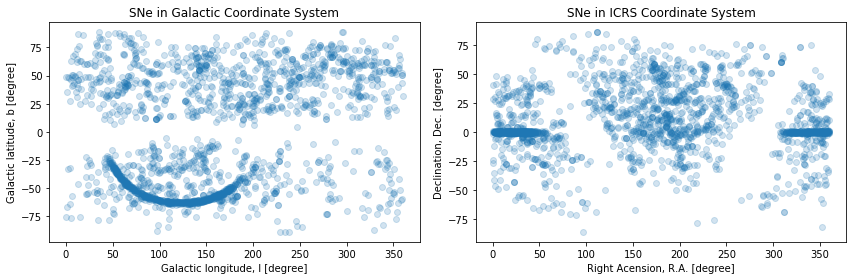

In [270]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax1 = ax[0]
ax1.plot(l, b, 'o', alpha = 0.2) #This needs to be fixed
ax1.set(xlabel = 'Galactic longitude, l [degree]',
        ylabel = 'Galactic latitude, b [degree]',
        title  = 'SNe in Galactic Coordinate System')

ax2 = ax[1]
ax2.plot(ra, dec, 'o', alpha = 0.2) #Will be using ICRS coordinates for Void Finder
ax2.set(xlabel = 'Right Acension, R.A. [degree]',
        ylabel = 'Declination, Dec. [degree]',
        title  = 'SNe in ICRS Coordinate System')

fig.tight_layout()

# This is currently a plot for 2035 SNe. See length of lists in above cell.

## Removing Stripe 82
### Plot of S82, Plot of SNe w/o S82

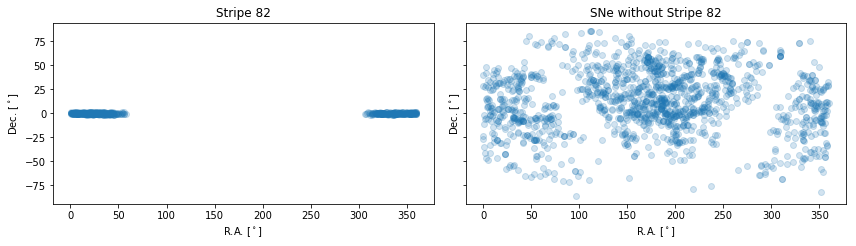

In [271]:
# Convert RA, Dec, z lists into numpy arrays.
# This allows for really fancy and fast vectorized boolean array slicing.
ra_array, dec_array, z_array, hRA_array, hDEC_array = np.asarray(ra), np.asarray(dec), np.asarray(z), np.asarray(hRA), np.asarray(hDEC)

# Stripe 82 cuts: 
ra_array_cut = np.logical_or(ra_array < 60., ra_array > 300.)
dec_array_cut = np.logical_and(dec_array > -1.26, dec_array < 1.26)
stripe82_cut = np.logical_and(ra_array_cut, dec_array_cut)

#Plots
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

ax = axes[0]
ax.plot(ra_array[stripe82_cut], dec_array[stripe82_cut], 'o', alpha=0.2)
ax.set(aspect='equal',
       xlabel=r'R.A. [$^\circ$]',
       ylabel=r'Dec. [$^\circ$]',
       title= 'Stripe 82')

ax = axes[1]
ax.plot(ra_array[~stripe82_cut], dec_array[~stripe82_cut], 'o', alpha=0.2)
ax.set(aspect='equal',
       xlabel=r'R.A. [$^\circ$]',
       ylabel=r'Dec. [$^\circ$]',
       title= 'SNe without Stripe 82')

fig.tight_layout()

In [272]:
len(ra_array[~stripe82_cut]), len(dec_array[~stripe82_cut]), len(z_array[~stripe82_cut])

(1445, 1445, 1445)

## Histogram of redshift, z

Go through the data table, extract z classified as "host" and "spectroscopic", put into a Python list, and plot in a histogram.

Make sure to check for valid entries.

Text(0.5, 0, 'redshift, z')

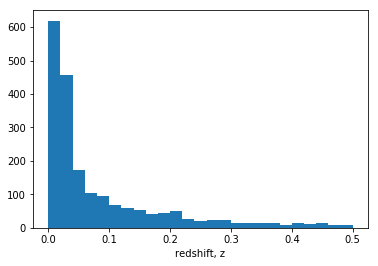

In [273]:
plt.hist(z, bins=np.linspace(0, 0.5, 26))
plt.xlabel('redshift, z')

## Output Catalog to File

Print selection we wrote to a file in various formats (JSON, ECSV, ...).

### Example: Manually Writing to a File

In [274]:
# with open('sn_coords_hosts.txt', 'w') as f:
#     f.write('# ID  NSA_RA  NSA_DEC  NSA_REDSHIFT\n')
#     for j, [ra_, dec_, z_, sntype_, host_] in enumerate(zip(ra, dec, z, sntype, host)):
#         f.write('{:5d} {:10.4f} {:10.4f} {:10.6f}\n'.format(j+1, ra_, dec_, z_))


# #This file save is for the Stripe 82 cut
# with open('sn_coords_hosts_noS82.txt', 'w') as f:
#     f.write('# ID  NSA_RA  NSA_DEC  NSA_REDSHIFT\n')
#     for j, [ra_, dec_, z_] in enumerate(zip(ra_array[~stripe82_cut], dec_array[~stripe82_cut], z)):
#         f.write('{:5d} {:10.4f} {:10.4f} {:10.6f}\n'.format(j+1, ra_, dec_, z_))
#         print('{:5d} {:10.4f} {:10.4f} {:10.6f}\n'.format(j+1, ra_, dec_, z_))


# with open('sn_host_radec.txt', 'w') as f:
#     f.write()

### Example: Using `astropy.table`

In [275]:
# tab = Table([ra, dec, z, sntype, host],
#             names=('NSA_RA', 'NSA_DEC', 'NSA_REDSHIFT', 'SNTYPE', 'HOST'))

# tab.write('sn_coord_host_table.ecsv', format='ascii.ecsv', overwrite=True)



# tab = Table([ra_array[~stripe82_cut], dec_array[~stripe82_cut], z[~stripe82_cut]],
#             names=('NSA_RA', 'NSA_DEC', 'NSA_REDSHIFT'))

# tab.write('sn_coord_host_noS82_table.ecsv', format='ascii.ecsv', overwrite=True)

# index = [i for i in range(len(ra_array))]

# tab = Table([index, ra_array, dec_array, hRA_array, hDEC_array],
#             names=('ID', 'SN_RA', 'SN_Dec','Host_RA', 'Host_Dec'))

# tab.write('NAME_ME', format='ascii.commented_header', overwrite=True)

#### Practice Reading an `astropy.table.Table`

## Appending petroMag_r to SN_table from queried table

In [282]:
SN_table = Table.read('C:/Users/kaeka/Documents/Python/sn_host_radec.txt', format='ascii.commented_header')
SN_table['rmag'] = -999.

mag_table = Table.read('C:/Users/kaeka/Documents/Python/sn_host_radec_rmag.csv', format='ascii.csv')

In [283]:
for i in range(len(mag_table)):
    gal_ID = mag_table['ID'][i]
    idx_bool = SN_table['ID'] == gal_ID
    SN_table['rmag'][idx_bool] = mag_table['petroMag_r'][i]
    
SN_table['SN_Redshift'] = z_array
SN_table['Host_Name'] = host
SN_table['SN_Type'] = sntype

In [284]:
SN_table

ID,SN_RA,SN_Dec,Host_RA,Host_Dec,rmag,SN_Redshift,Host_Name,SN_Type
int32,float64,float64,float64,float64,float64,float64,str93,str39
0,353.3018916666666,-60.57475,353.3009583333333,-60.572250000000004,-999.0,0.014827,2MASX J23331223-6034201,Candidate
1,227.9278708333333,6.4198611111111115,227.92749999999998,6.419972222222222,16.59179,0.031916,SDSS J151142.60+062511.9,Ibn
2,59.18707916666666,-5.270861111111111,59.195249999999994,-5.272833333333334,17.12867,0.06557,SDSS J035646.86-051622.2,Comet
3,358.41844999999995,-34.07431944444445,358.4177083333333,-34.07505555555556,-999.0,0.056,2MASS J23534025-3404302,Candidate
4,67.2558,-61.280338888888885,67.25695833333332,-61.280833333333334,-999.0,0.064,GALEXASC J042901.67-611651.0,Candidate
5,96.32085,-85.69826111111111,96.38233333333332,-85.69855555555556,-999.0,0.041665,2MASX J06253176-8541548,Candidate
6,343.12232083333333,-11.090411111111111,343.1219166666666,-11.092222222222222,-999.0,0.025271,2MASX J22522926-1105320,Candidate
7,179.38309999999998,0.816625,179.38104166666662,0.8171111111111111,16.42431,0.06227,SDSS J115731.45+004901.6,Candidate
8,204.62057083333332,2.5287055555555553,204.62116666666665,2.5283333333333333,18.73739,0.017996,SDSS J133829.08+023142.0,Candidate


In [285]:
SN_table.write('sn_host_radec_rmag_sortedID.txt', format='ascii.commented_header', overwrite=True)

In [286]:
# SN_table.pprint(max_lines=-1, max_width=-1)  # Print full table no matter how long / wide it is

## Calculating the Absolute Magnitude

From "sn_host_radec_rmag_sortedID.txt," we will take the rmag and redshift to calculate the absolute magnitude for the host galaxies of the SNe.

In [287]:
Abs_table = Table.read('C:/Users/kaeka/Documents/Python/jupyter notebook/sn_host_radec_rmag_sortedID.txt', format='ascii.commented_header')
Abs_table

ID,SN_RA,SN_Dec,Host_RA,Host_Dec,rmag,SN_Redshift,Host_Name,SN_Type
int32,float64,float64,float64,float64,float64,float64,str93,str39
0,353.3018916666666,-60.57475,353.3009583333333,-60.572250000000004,-999.0,0.014827,2MASX J23331223-6034201,Candidate
1,227.9278708333333,6.4198611111111115,227.92749999999998,6.419972222222222,16.59179,0.031916,SDSS J151142.60+062511.9,Ibn
2,59.18707916666666,-5.270861111111111,59.195249999999994,-5.272833333333334,17.12867,0.06557,SDSS J035646.86-051622.2,Comet
3,358.41844999999995,-34.07431944444445,358.4177083333333,-34.07505555555556,-999.0,0.056,2MASS J23534025-3404302,Candidate
4,67.2558,-61.280338888888885,67.25695833333332,-61.280833333333334,-999.0,0.064,GALEXASC J042901.67-611651.0,Candidate
5,96.32085,-85.69826111111111,96.38233333333332,-85.69855555555556,-999.0,0.041665,2MASX J06253176-8541548,Candidate
6,343.12232083333333,-11.090411111111111,343.1219166666666,-11.092222222222222,-999.0,0.025271,2MASX J22522926-1105320,Candidate
7,179.38309999999998,0.816625,179.38104166666662,0.8171111111111111,16.42431,0.06227,SDSS J115731.45+004901.6,Candidate
8,204.62057083333332,2.5287055555555553,204.62116666666665,2.5283333333333333,18.73739,0.017996,SDSS J133829.08+023142.0,Candidate


In [288]:
np.sum(Abs_table['rmag'] == -999.)

572

In [298]:
# Calculating absolute magnitude.
def abs_mag(m, z, K=0, h=1.):
    """Convert apparent magnitude to absolute magnitude using the distance modulus
    
    M - m = 5 log10(d / 10 pc), where d = cz/H0 (assuming z < 0.1)
    
    Parameters
    ----------
    m : float
        Apparent magnitude; assume r-band.
    z : flaot
        Redshift.
    K : float
        K-correction.
    h : float
        Dimensionless scaling parameter for Hubble's constant H0.
        
    Returns
    -------
    M : float
        Absolute magnitude (assume r-band).
    """
    H0 = 100 * u.km/u.s/u.Mpc * h
    d = (c* z / H0)
    M = m - 5*np.log10(d / (10*u.pc)) - K
    
    return M

In [299]:
Abs_table['AbsMag'] = abs_mag(Abs_table['rmag'], Abs_table['SN_Redshift'])

Abs_table = Abs_table['ID', 'SN_Type', 'SN_Redshift', 'SN_RA', 'SN_Dec', 'Host_Name', 'Host_RA', 'Host_Dec', 'rmag', 'AbsMag']

for i in range(len(Abs_table)):
    no_rmag = Abs_table['rmag'] == -999
    Abs_table['AbsMag'][no_rmag] = -999.

## Append the environment classifications.

In [300]:
vflag_table = QTable.read('C:/Users/kaeka/Documents/Python/jupyter notebook/sn_coord_host_table_vflag.txt', format= 'ascii.ecsv')

In [301]:
Abs_table['vflag'] = -999

for i in range(len(Abs_table)):
    host = vflag_table['HOST'][i]
    host_bool = Abs_table['Host_Name'] == host
    Abs_table['vflag'][host_bool] = vflag_table['vflag'][i]

In [302]:
Abs_table

# np.sum(Abs_table['vflag'] == -999)

ID,SN_Type,SN_Redshift,SN_RA,SN_Dec,Host_Name,Host_RA,Host_Dec,rmag,AbsMag,vflag
,,,,,,,,,,
int32,str39,float64,float64,float64,str93,float64,float64,float64,float64,int32
0,Candidate,0.014827,353.3018916666666,-60.57475,2MASX J23331223-6034201,353.3009583333333,-60.572250000000004,-999.0,-999.0,-9
1,Ibn,0.031916,227.9278708333333,6.4198611111111115,SDSS J151142.60+062511.9,227.92749999999998,6.419972222222222,16.59179,-18.31235579664487,0
2,Comet,0.06557,59.18707916666666,-5.270861111111111,SDSS J035646.86-051622.2,59.195249999999994,-5.272833333333334,17.12867,-19.338959432972217,-9
3,Candidate,0.056,358.41844999999995,-34.07431944444445,2MASS J23534025-3404302,358.4177083333333,-34.07505555555556,-999.0,-999.0,-9
4,Candidate,0.064,67.2558,-61.280338888888885,GALEXASC J042901.67-611651.0,67.25695833333332,-61.280833333333334,-999.0,-999.0,-9
5,Candidate,0.041665,96.32085,-85.69826111111111,2MASX J06253176-8541548,96.38233333333332,-85.69855555555556,-999.0,-999.0,-9
6,Candidate,0.025271,343.12232083333333,-11.090411111111111,2MASX J22522926-1105320,343.1219166666666,-11.092222222222222,-999.0,-999.0,-9
7,Candidate,0.06227,179.38309999999998,0.816625,SDSS J115731.45+004901.6,179.38104166666662,0.8171111111111111,16.42431,-19.93118784324664,1


In [303]:
Abs_table.write('sn_host_radec_absMag_vflag.txt', format='ascii.commented_header', overwrite=True)